# Structure Function Turbulent Data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

import torch
from turboflow.models.rff import RFFNet
from turboflow.dataloaders import Turbo2D_simple, load_turbo2D_simple_numpy
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

# set up cuda 
torch.cuda.is_available()
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [3]:
# ds=downsampling factor
Xlr, Ulr = load_turbo2D_simple_numpy(ds=4) # low resolution (64x64)
Xmr, Umr = load_turbo2D_simple_numpy(ds=2) # mid resolution (128x128)
Xhr, Uhr = load_turbo2D_simple_numpy(ds=1) # high (max) resolution (256x256)

L = int(Xlr.shape[0]**0.5)
M = int(Xmr.shape[0]**0.5)
H = int(Xhr.shape[0]**0.5)

Y shape (64, 64, 2)
Y min, max: -2.365612 2.941536
after normalization, Y min, max: -0.8042097733972999 1.0
Y shape (128, 128, 2)
Y min, max: -2.371183 2.985797
after normalization, Y min, max: -0.7941541236728418 1.0
Y shape (256, 256, 2)
Y min, max: -2.382122 2.999472
after normalization, Y min, max: -0.7941804424245333 1.0


In [10]:
from turboflow.models.rff import RFFNet

# model (RFF + MLP)
fft_scale = 10
fft_nfeat = 256
nin = 2  # = x and y coordinates
nout = 2 # = ux and uy components
mlp_layers = [nin*fft_nfeat] + [256]*3 + [nout]

rffnet = RFFNet('RFFNet', mlp_layers, fft_nfeat, fft_scale)

# training data
path_to_data = '../data/2021-Turb2D_velocities.npy'
trainset = Turbo2D_simple(path_to_data, device, ds=4, img=42)
trainloader = DataLoader(trainset, batch_size=6666, shuffle=False)

# TRAIN!
rffnet.to(device)
rffnet.fit(trainloader, epochs=2000) # we are not afraid to overfit the data, this is coord-based MLP!

Dataset Turbo2D, img # 42
(64, 64, 2)
(64, 64, 2)
Original size 64
Y shape (64, 64, 2)
Y min, max: -2.365612 2.941536
after normalization, Y min, max: -0.8042097733972999 1.0
Epoch: 100, Loss: 0.002288
Epoch: 200, Loss: 0.000053
Epoch: 300, Loss: 0.000007
Epoch: 400, Loss: 0.000002
Epoch: 500, Loss: 0.000001
Epoch: 600, Loss: 0.000001
Epoch: 700, Loss: 0.000002
Epoch: 800, Loss: 0.000000
Epoch: 900, Loss: 0.000000
Epoch: 1000, Loss: 0.000005
Epoch: 1100, Loss: 0.000000
Epoch: 1200, Loss: 0.000002
Epoch: 1300, Loss: 0.000001
Epoch: 1400, Loss: 0.000000
Epoch: 1500, Loss: 0.000000
Epoch: 1600, Loss: 0.000000
Epoch: 1700, Loss: 0.000003
Epoch: 1800, Loss: 0.000004
Epoch: 1900, Loss: 0.000000
Epoch: 2000, Loss: 0.000000
Done with Training
Final error: 1.011528866001754e-06


In [11]:
from turboflow.models.phyrff_soft import PiRFFNet

# model (RFF + MLP)
fft_scale = 10
fft_nfeat = 256
nin = 2
nout = 2
mlp_layers = [nin*fft_nfeat] + [256]*3 + [nout]

pirffntet = PiRFFNet('PIRFFNet', mlp_layers, fft_nfeat, fft_scale)

# training data
path_to_data = '../data/2021-Turb2D_velocities.npy'
trainset = Turbo2D_simple(path_to_data, device, img=42)
trainloader = DataLoader(trainset, batch_size=6666, shuffle=False)

# TRAIN!
pirffntet.to(device)
pirffntet.fit(trainloader, epochs=2000)

Dataset Turbo2D, img # 42
(64, 64, 2)
(64, 64, 2)
Original size 64
Y shape (64, 64, 2)
Y min, max: -2.365612 2.941536
after normalization, Y min, max: -0.8042097733972999 1.0
Epoch: 100, Loss: (0.016082 + 139.652405) = 0.030047
Epoch: 200, Loss: (0.001960 + 78.042183) = 0.009765
Epoch: 300, Loss: (0.000919 + 63.493893) = 0.007268
Epoch: 400, Loss: (0.000652 + 55.858860) = 0.006238
Epoch: 500, Loss: (0.000498 + 50.248192) = 0.005523
Epoch: 600, Loss: (0.000414 + 44.486004) = 0.004862
Epoch: 700, Loss: (0.000357 + 42.071507) = 0.004564
Epoch: 800, Loss: (0.000307 + 39.161522) = 0.004223
Epoch: 900, Loss: (0.000269 + 36.732918) = 0.003942
Epoch: 1000, Loss: (0.000254 + 33.550888) = 0.003609
Epoch: 1100, Loss: (0.000224 + 32.650120) = 0.003489
Epoch: 1200, Loss: (0.000209 + 31.883961) = 0.003398
Epoch: 1300, Loss: (0.000187 + 30.831993) = 0.003270
Epoch: 1400, Loss: (0.000180 + 27.251350) = 0.002905
Epoch: 1500, Loss: (0.000165 + 27.581232) = 0.002923
Epoch: 1600, Loss: (0.000160 + 26.5681

In [5]:
# training data
path_to_data = '../data/2021-Turb2D_velocities.npy'
trainset = Turbo2D_simple(path_to_data, device, ds=4, img=42)
trainloader = DataLoader(trainset, batch_size=6666, shuffle=False)

X, y = trainset[:5]
delta_x = (X[2,1] - X[1,1]).item()
smallest_increment = delta_x/4

Dataset Turbo2D, img # 42
(64, 64, 2)
(64, 64, 2)
Original size 64
Y shape (64, 64, 2)
Y min, max: -2.365612 2.941536
after normalization, Y min, max: -0.8042097733972999 1.0


In [6]:
from turboflow.models.phyrff_sfun import SfunRFFNet

# model (RFF + MLP)
fft_scale = 10
fft_nfeat = 256
nin = 2  # = x and y coordinates
nout = 2 # = ux and uy components
mlp_layers = [nin*fft_nfeat] + [256]*3 + [nout]

# model
n_centers = 50 # 100 too much
n_increments = 5
sfunrffnet = SfunRFFNet('SfunRFFNet', mlp_layers, fft_nfeat, fft_scale,
                        smallest_increment = smallest_increment,
                        n_centers=n_centers, n_increments=n_increments)

sfunrffnet.to(device)
sfunrffnet.fit(trainloader, epochs=6000) # we are not afraid to overfit the data, this is coord-based MLP!

Epoch: 100, Loss: (0.040867 + 0.006933 + 0.014108) = 0.061908
Epoch: 200, Loss: (0.011620 + 0.003723 + 0.007858) = 0.023201
Epoch: 300, Loss: (0.003862 + 0.002564 + 0.006527) = 0.012953
Epoch: 400, Loss: (0.002098 + 0.002771 + 0.005626) = 0.010495
Epoch: 500, Loss: (0.001508 + 0.001783 + 0.005292) = 0.008584
Epoch: 600, Loss: (0.001310 + 0.001777 + 0.004637) = 0.007724
Epoch: 700, Loss: (0.001256 + 0.001425 + 0.004432) = 0.007113
Epoch: 800, Loss: (0.001127 + 0.001352 + 0.004334) = 0.006812
Epoch: 900, Loss: (0.001103 + 0.002772 + 0.004028) = 0.007903
Epoch: 1000, Loss: (0.000842 + 0.001239 + 0.003961) = 0.006042
Epoch: 1100, Loss: (0.000857 + 0.003708 + 0.003861) = 0.008426
Epoch: 1200, Loss: (0.000843 + 0.001182 + 0.003897) = 0.005922
Epoch: 1300, Loss: (0.000779 + 0.003016 + 0.003689) = 0.007483
Epoch: 1400, Loss: (0.000843 + 0.001548 + 0.003615) = 0.006005
Epoch: 1500, Loss: (0.000834 + 0.001105 + 0.003456) = 0.005394
Epoch: 1600, Loss: (0.000746 + 0.001464 + 0.003484) = 0.005694
E

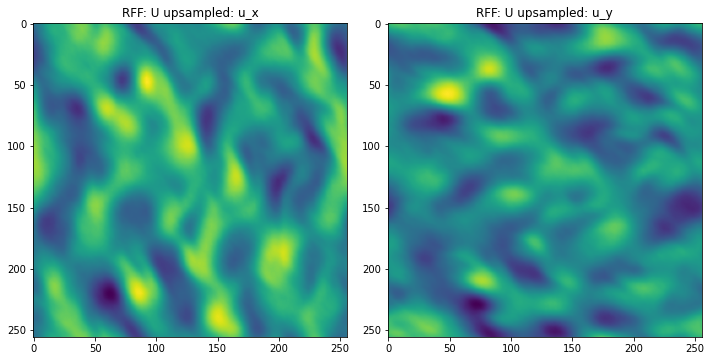

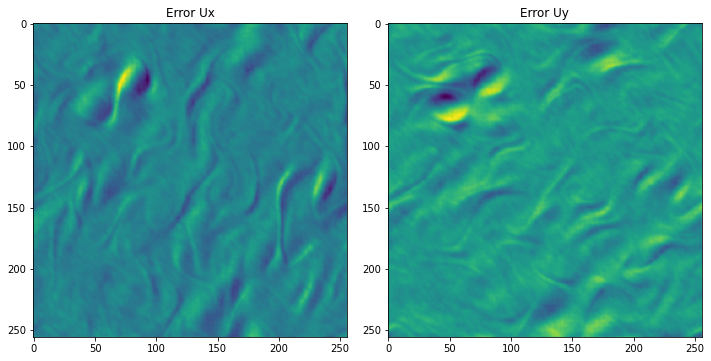

In [7]:
x = torch.from_numpy(Xhr).float().contiguous().to(device)

sfunrffnet.eval().to(device)
pred = sfunrffnet(x)
Udfphy = pred.cpu().detach().numpy().squeeze().reshape(H,H,2)

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.title('RFF: U upsampled: u_x')
plt.imshow(Udfphy[:,:,0])
plt.subplot(122)
plt.title('RFF: U upsampled: u_y')
plt.imshow(Udfphy[:,:,1])
plt.tight_layout()
plt.show()


plt.figure(figsize=(10,10))
plt.subplot(121)
plt.title('Error Ux')
plt.imshow(Udfphy[:,:,0] - Uhr.reshape(H,H,2)[:,:,0])
plt.subplot(122)
plt.title('Error Uy')
plt.imshow(Udfphy[:,:,1] - Uhr.reshape(H,H,2)[:,:,1])
plt.tight_layout()
plt.show()

In [12]:
x = torch.from_numpy(Xhr).float().contiguous().to(device)

Upde = pirffntet(x).cpu().detach().numpy().squeeze()
Usfun = sfunrffnet(x).cpu().detach().numpy().squeeze()
Urff = rffnet(x).cpu().detach().numpy().squeeze()

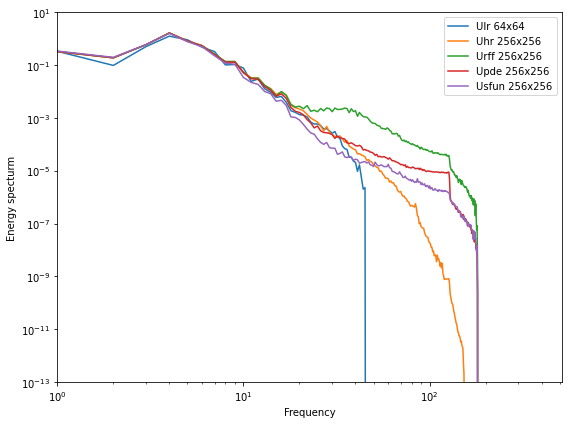

In [13]:
from turboflow.utils import phy_utils as phy

fig, axs = plt.subplots(1,1,figsize=(8,6))
axs.loglog(np.arange(len(phy.powerspec(Ulr.reshape(L,L,2)[:,:,1]))), 
                         phy.powerspec(Ulr.reshape(L,L,2)[:,:,1]), label='Ulr 64x64')
axs.loglog(np.arange(len(phy.powerspec(Uhr.reshape(H,H,2)[:,:,0]))), 
                         phy.powerspec(Uhr.reshape(H,H,2)[:,:,0]), label='Uhr 256x256')
axs.loglog(np.arange(len(phy.powerspec(Urff.reshape(H,H,2)[:,:,0]))), 
                         phy.powerspec(Urff.reshape(H,H,2)[:,:,0]), label='Urff 256x256')
axs.loglog(np.arange(len(phy.powerspec(Upde.reshape(H,H,2)[:,:,0]))), 
                         phy.powerspec(Upde.reshape(H,H,2)[:,:,0]), label='Upde 256x256')
axs.loglog(np.arange(len(phy.powerspec(Usfun.reshape(H,H,2)[:,:,0]))), 
                         phy.powerspec(Usfun.reshape(H,H,2)[:,:,0]), label='Usfun 256x256')
axs.set_ylim(10**(-13), 10)
axs.set_xlim(1, 512)
axs.legend()
plt.ylabel('Energy specturm')
plt.xlabel('Frequency')
plt.tight_layout()
plt.show()

(65536, 2)


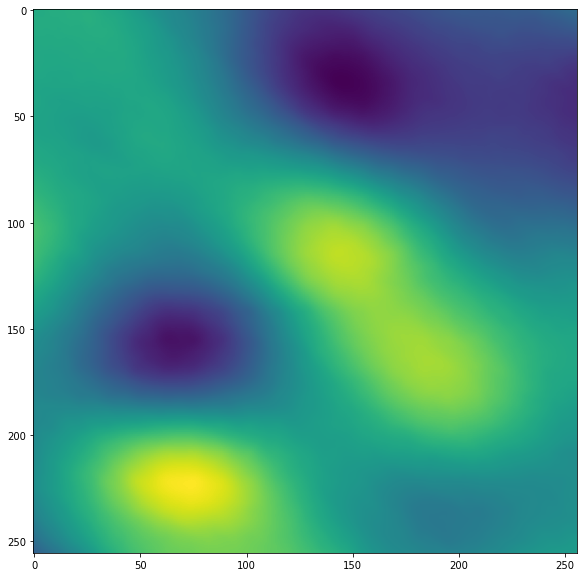

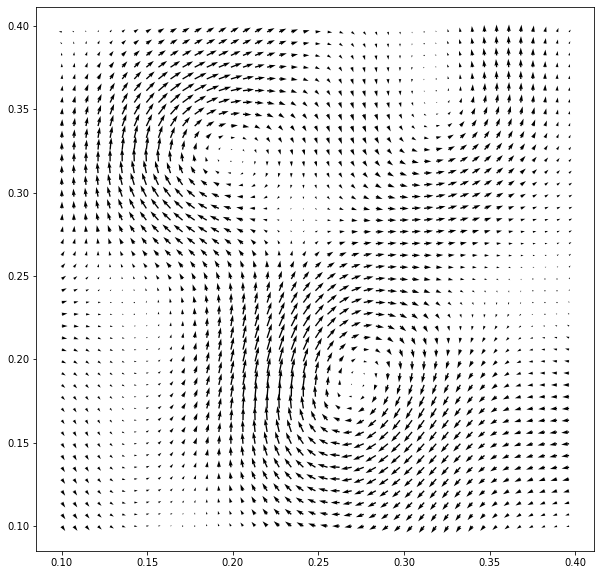

In [14]:
# Let s zoom in it!
ngrid = 256
coords = np.linspace(0.1, 0.4, ngrid)
coords = np.stack(np.meshgrid(coords, coords), -1) # X x Y x 2
coords = coords.reshape(ngrid*ngrid,2)
print(coords.shape)

x = torch.from_numpy(coords).float().contiguous().to(device)

sfunrffnet.eval().to(device)
pred = sfunrffnet(x)
pred = pred.cpu().detach().numpy().squeeze().reshape(ngrid,ngrid,2)

plt.figure(figsize=(10,10))
plt.imshow(pred[:,:,0])
plt.show()

s = 6
plt.figure(figsize=(10,10))
plt.quiver(coords.reshape(ngrid,ngrid,2)[::s,::s,0],
           coords.reshape(ngrid,ngrid,2)[::s,::s,1],
           pred[::s,::s,0],pred[::s,::s,1])